# Resilient Policy Search

In [41]:
'''
Set-up:
1) Many states and actions
2) Infeasibile initial constraints
3) Use ResPG-PD, ResOPG-PD

'''

'\nSet-up:\n1) Many states and actions\n2) Infeasibile initial constraints\n3) Use ResPG-PD, ResOPG-PD\n\n'

In [42]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import linprog

## Generate random MDP

In [43]:
## Random Seed
np.random.seed(10)
## Problem Setup
gamma = 0.9
n, m = 20, 5 # s, a
# n, m = 2, 2 # s, a
'''
Randomly generated probability transition matrix P((s,a) -> s') in R^{|S||A| x |S|}
Each row sums up to one
'''
raw_transition = np.random.uniform(0,1,size=(n*m,n))
prob_transition = raw_transition/raw_transition.sum(axis=1,keepdims=1)
'''
Random positive rewards
'''
reward = np.random.uniform(0,1,size=(n*m))

'''
Random utilities between -1 and +1
'''
utility = np.random.uniform(-1,1,size=(n*m))

'''
Initial constraints
'''
u_constraint = 8

'''
Start state distribution
'''
rho = np.ones(n)/n

## Useful functions

In [44]:
'''
Input: theta as an array and
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        for j in range(m*i,m*(i+1)):
            prob.append(np.exp(theta[j])/norm)

    return np.asarray(prob)


"""
Input: Discrete probability distributions p, q : array-like, dtype=float, shape=n
Output: Kullback-Leibler divergence D(p||q)
"""
def kl_div(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [45]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|S| x |S||A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n,n*m))
    for i in range(n):
        Pi[i,i*m:(i+1)*m] = prob[i*m:(i+1)*m]

    return Pi

In [46]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])

    ell = np.dot(V,rho)
    return ell

In [47]:
'''
Input: theta as an array and
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def project_to_policy(theta,n,m):
    prob = []
    prob_pers = []
    for i in range(n):
#         norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        prob_pers = projection_simplex_sort(theta[m*i:m*(i+1)], z=1)
        for j in range(m):
            prob.append(prob_pers[j])

    return np.asarray(prob)

In [48]:
'''
The projection function
Input: a scalar
Output: a scalar in the interval [0 C]
'''
def proj(scalar,gamma):
    offset = 1000/(1-gamma)
    if scalar < 0:
        scalar = 0

    if scalar > offset:
        scalar = offset

    return scalar

In [49]:
"""
License: BSD
Author: Mathieu Blondel
Implements three algorithms for projecting a vector onto the simplex: sort, pivot and bisection.
For details and references, see the following paper:
Large-scale Multiclass Support Vector Machine Training via Euclidean Projection onto the Simplex
Mathieu Blondel, Akinori Fujino, and Naonori Ueda.
ICPR 2014.
http://www.mblondel.org/publications/mblondel-icpr2014.pdf
"""

def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_bisection(v, z=1, tau=0.0001, max_iter=1000):
    func = lambda x: np.sum(np.maximum(v - x, 0)) - z
    lower = np.min(v) - z / len(v)
    upper = np.max(v)

    for it in range(max_iter):
        midpoint = (upper + lower) / 2.0
        value = func(midpoint)

        if abs(value) <= tau:
            break

        if value <= 0:
            upper = midpoint
        else:
            lower = midpoint

    return np.maximum(v - midpoint, 0)

In [50]:
'''
Input: theta as an array
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy_naive(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(theta[m*i:m*(i+1)])
        for j in range(m*i,m*(i+1)):
            prob.append(theta[j]/norm)

    return np.asarray(prob)

In [51]:
'''
The projection function for xi
Input: a scalar
Output: a scalar in the interval [-C C]
'''

def proj_xi(scalar, gamma):
    max = 0#1/(1-gamma)
    min = -2/(1-gamma)

    if scalar < min:
        scalar = min;
    if scalar > max:
        scalar = max

    return scalar

## Check the lower bound of infeasible constraints

In [52]:
#Compute the optimal reward value from LP

## linear programming solver

# minimize A_ub @ x
#
# such that
#
#          A_eq @ x == b_eq
#          lb <= x <= ub

c = -reward
A_ub = -utility.reshape(1, n*m)
b_ub = np.zeros(1)+1/(1-gamma)

prob_transition_lp = np.transpose(prob_transition)

E_sum = np.full_like(prob_transition_lp, 0)
for i in range(n):
    E_sum[i,m*i:m*(i+1)] = np.ones(m)

A_eq = E_sum - gamma*prob_transition_lp
b_eq = rho

lb = np.zeros(n*m)
ub = np.ones(n*m)
ub = ub/(1-gamma)
bounds = np.transpose([lb, ub])

eps = 0.001

res = linprog(A_ub, None, None, A_eq, b_eq, bounds)

print('If u_constraint is greater than',-res.fun, 'the problem become infeasible')



If u_constraint is greater than 5.556458336351499 the problem become infeasible


## Resilient Policy Gradient Primal-Dual (ResPG-PD) Method

In [53]:
'''
Policy search via ResPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''

def NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = np.array([]) ):


    theta = np.random.uniform(0,1,size=n*m)
    dual = 0
    dual_h = 0
    xi =0
    xi_h = 0
    reward_value = []
    utility_value = []
    xi_value = []
    distance = []


    theta = project_to_policy(theta,n,m)

    # Transform into V_{g'}>=\xi
    utility = utility - init_constraint*(1-gamma)

    # derivative of relaxation function
    dh = lambda x:2*alpha*(x)
    for k in range(total_iterates):

        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
        violation_gradient = ell(qvals_utility,theta,rho) - xi

        # gradient
        qvals = qvals_reward + dual*qvals_utility

        # natural gradient ascent
        theta = project_to_policy(theta + stepsize*qvals,n,m)

        # update xi
        grad_xi = -(dh(xi)+dual)
        xi = xi + stepsize*grad_xi
        xi = proj_xi(xi,gamma)

        # dual descent
        dual = dual - stepsize*violation_gradient
        dual = proj(dual,gamma)


        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta,rho)
              avg_utility = ell(qvals_utility,theta,rho)
              reward_value.append(avg_reward)
              utility_value.append(avg_utility)
              xi_value.append(xi)
              if len(optimal_policy) != 0:
                policy = theta_to_policy(theta,n,m)
                policy_norm_squared = np.inner(theta - optimal_policy, theta - optimal_policy)
                distance.append(policy_norm_squared)




    if show_detail == True:
        return reward_value, utility_value, xi_value, distance
    else:
        reward_value = ell(qvals_reward,theta,rho)
        utility_value = ell(qvals_utility,theta,rho)
        return reward_value, utility_value, xi_h



## Resilient Optimistic Policy Gradient Primal-Dual (ResOPG-PD) Method

In [54]:
'''
Policy search via ResOPG-PD
Input: n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None
Output: function values of reward, utility and relaxation (show_detail == False)
    Vectors containing the values of reward, utility, relaxation and policy optimality gap during training process (show_detail == True)
'''

def Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, init_constraint, show_detail = True, optimal_policy = None ):


    theta = np.random.uniform(0,1,size=n*m)
    theta_h = np.random.uniform(0,1,size=n*m)
    theta = project_to_policy(theta,n,m)
    theta_h = project_to_policy(theta_h,n,m)
    dual = 0
    dual_h = 0
    xi = 0
    xi_h = 0
    reward_value = []
    utility_value = []
    xi_value = []
    distance = []


    # Transform into V_{g'}>=\xi
    utility = utility - init_constraint*(1-gamma)

    # derivative of relaxation function
    dh = lambda x:2*alpha*(x)

    for k in range(total_iterates):

        # optimistic step for (theta, dual)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
        violation_gradient = ell(qvals_utility,theta,rho) - xi

        # gradient
        qvals = qvals_reward + dual*qvals_utility

        # natural gradient ascent
        theta = project_to_policy(theta_h + stepsize*qvals,n,m)


        # update xi
        grad_xi = -(dh(xi)+dual)
        xi = xi_h + stepsize*grad_xi
        xi = proj_xi(xi,gamma)

        # dual descent
        dual = dual_h - stepsize*violation_gradient
        dual = proj(dual,gamma)


        # optimistic step for (theta_h, dual_h)
        Pi = get_Pi(theta,n,m)
        mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
        qvals_reward = np.dot(np.linalg.inv(mat),reward)
        qvals_utility = np.dot(np.linalg.inv(mat),utility)
        violation_gradient = ell(qvals_utility,theta,rho) - xi

        # gradient
        qvals = qvals_reward + dual*qvals_utility

        # natural gradient ascent
        theta_h = project_to_policy(theta_h + stepsize*qvals,n,m)

        # update xi_h
        grad_xi = -(dh(xi)+dual)
        xi_h = xi_h + stepsize*grad_xi
        xi_h = proj_xi(xi_h,gamma)

        # dual desceent
        dual_h = dual_h - stepsize*violation_gradient
        dual_h = proj(dual_h,gamma)


        # record
        if show_detail == True:
          if k % 1 == 0:
              avg_reward = ell(qvals_reward,theta_h,rho)
              avg_utility = ell(qvals_utility,theta_h,rho)
              reward_value.append(avg_reward)
              utility_value.append(avg_utility)
              xi_value.append(xi)
              if len(optimal_policy) != 0:
                policy = theta_to_policy(theta,n,m)

                policy_norm_squared = np.inner(theta_h - optimal_policy, theta_h - optimal_policy)
                distance.append(policy_norm_squared)




    if show_detail == True:
        return reward_value, utility_value, xi_value, distance
    else:
        reward_value = ell(qvals_reward,theta_h,rho)
        utility_value = ell(qvals_utility,theta_h,rho)
        return reward_value, utility_value, xi_h



## Quadratic Programming Solver for optimality

In [55]:
import numpy
import cvxopt
import cvxopt.solvers
from cvxopt import matrix, solvers

alpha_list = [0.0001,0.005, 0.01,0.03, 0.2, 1]

#Compute the optimal reward value from QP


# x = [theta xi]
# minimize 1/2x^T@Q@x + c^T@x
#
# such that
#          A_ub @ x <= b_ub, lb <= x <= ub  ----> [I -I A_ub] @ x <= [ub -lb b_ub]
#          A_eq @ x == b_eq
#
#

utilityp = utility - (1-gamma)*u_constraint
optimal_dict = {}

for alpha in alpha_list:
  cur_dict = {}
  c = -reward
  c = np.append(c,0)
  Q = np.zeros([m*n+1,m*n+1])
  Q[m*n,m*n] = 2*alpha

  A_ub0 = -np.append(utilityp, -1).reshape(1, n*m+1)
  b_ub0 = np.zeros(1)

  prob_transition_lp = np.transpose(prob_transition)

  E_sum = np.full_like(prob_transition_lp, 0)
  for i in range(n):
      E_sum[i,m*i:m*(i+1)] = np.ones(m)

  A_eq = E_sum - gamma*prob_transition_lp
  A_eq = np.hstack((A_eq, np.zeros((n, 1))))
  b_eq = rho



  A_ub1 = np.eye(m*n+1)
  A_ub2 = -np.eye(m*n+1)
  A_ub = np.concatenate([A_ub1,A_ub2,A_ub0],axis = 0)

  b_ub = np.zeros(2*(m*n+1)+1)
  b_ub[0:m*n] = 1/(1-gamma)
  b_ub[m*n+1:2*(m*n)+1] = 0
  b_ub[m*n] = 0
  b_ub[2*m*n+1] = 2*1/(1-gamma)
  b_ub[2*m*n+2] = b_ub0

  eps = 0.001

  Q = cvxopt.matrix(Q)
  A_ub = cvxopt.matrix(A_ub)
  c = cvxopt.matrix(c)
  b_ub = cvxopt.matrix(b_ub)
  A_eq = cvxopt.matrix(A_eq)
  b_eq = cvxopt.matrix(b_eq)

  res = cvxopt.solvers.qp(Q, c, A_ub, b_ub, A_eq, b_eq)

  optx = res['x']

  theta = np.array(optx)[0:m*n]
  u = utilityp.reshape(1, n*m)
  r = reward.reshape(1, n*m)

  cur_dict['reward'] = r@theta
  cur_dict['utility'] = u@theta
  cur_dict['xi'] = optx[-1]
  cur_dict['policy'] = theta_to_policy_naive(theta,n,m)[:,0]

  optimal_dict[alpha] = cur_dict





     pcost       dcost       gap    pres   dres
 0: -8.0955e+00 -1.4112e+03  3e+03  2e-01  2e+01
 1: -5.2177e+00 -1.4688e+02  2e+02  4e-03  5e-01
 2: -5.2464e+00 -1.2967e+01  8e+00  8e-05  1e-02
 3: -7.2114e+00 -9.9606e+00  3e+00  1e-05  2e-03
 4: -8.2304e+00 -8.8887e+00  7e-01  1e-06  2e-04
 5: -8.3914e+00 -8.4889e+00  1e-01  1e-07  1e-05
 6: -8.4239e+00 -8.4264e+00  2e-03  1e-09  2e-07
 7: -8.4248e+00 -8.4248e+00  2e-05  1e-11  2e-09
 8: -8.4248e+00 -8.4248e+00  2e-07  1e-13  2e-11
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.6169e+00 -1.4104e+03  3e+03  2e-01  2e+01
 1: -4.6994e+00 -1.4602e+02  2e+02  4e-03  5e-01
 2: -4.7756e+00 -1.4000e+01  9e+00  1e-04  2e-02
 3: -6.4517e+00 -9.4160e+00  3e+00  2e-05  3e-03
 4: -7.7177e+00 -8.4170e+00  7e-01  3e-06  4e-04
 5: -7.9521e+00 -8.0185e+00  7e-02  2e-07  3e-05
 6: -7.9761e+00 -7.9799e+00  4e-03  5e-09  6e-07
 7: -7.9775e+00 -7.9775e+00  4e-05  5e-11  6e-09
 8: -7.9775e+00 -7.9775e+00  4e-07  5e-13  6e-1

In [56]:
optimal_dict

{0.0001: {'reward': array([[8.434389]]),
  'utility': array([[-9.790727]]),
  'xi': -9.790727129220059,
  'policy': array([0.000000, 1.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.000000,
         0.000000, 0.000000, 0.000000, 1.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.000000,
         1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.000000,
         0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
         1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 1.000000,
         0.000000, 0.000000, 0.000000, 1.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 1.000000, 0.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 1.000000, 0.000000, 0.000000,
         0.000000, 0.000000, 0.000000, 1.000000, 0.000000, 0.000000,
         1.000000, 0.000000, 0.000000, 0.000000, 0.000000,

## Call 2 methods

In [57]:
# call ResOPG-PD

total_iterates = 3000
stepsize = 0.2

alpha_list = [0.005, 0.01,0.03, 0.2, 1]
# alpha_list = [0.0001]

opt_resilient_reward = []
opt_resilient_utility = []
opt_resilient_xi = []
opt_dist = []
for alpha in alpha_list:
    resilient_reward_value_opt, resilient_utility_value_opt, resilient_xi_value_opt, policy_distance = Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates,u_constraint, show_detail = True, optimal_policy=optimal_dict[alpha]['policy'])
    opt_resilient_reward.append(resilient_reward_value_opt)
    opt_resilient_utility.append(resilient_utility_value_opt)
    opt_resilient_xi.append(resilient_xi_value_opt)
    opt_dist.append(policy_distance)




In [61]:

#  call ResPG-PD


total_iterates = 3000
stepsize = 0.2

alpha_list = [0.005, 0.01,0.03, 0.2, 1]
# alpha_list = [0.0001]

resilient_reward = []
resilient_utility = []
resilient_xi = []
dist = []
for alpha in alpha_list:
    resilient_reward_value_opt, resilient_utility_value_opt, resilient_xi_value_opt, policy_distance = NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates,u_constraint, show_detail = True, optimal_policy=optimal_dict[alpha]['policy'])
    resilient_reward.append(resilient_reward_value_opt)
    resilient_utility.append(resilient_utility_value_opt)
    resilient_xi.append(resilient_xi_value_opt)
    dist.append(policy_distance)


## Plot reward, utility and relaxation vs iterations

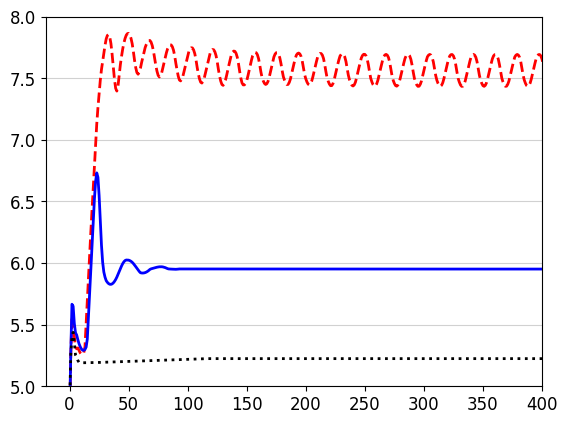

In [62]:
# plot reward value vs policy iterate

plt.rcParams.update(plt.rcParamsDefault)
color_list = ['red','blue','black']
linestyle = ['--','-','dotted']


fontsize = 28
axisfontsize = 12
f_value = plt.figure

num_every = 1
num_grads = np.arange(0, total_iterates, num_every)
yaxismin = -20
yaxismax = 400


draw_index = [2,3,4]


# Plot for ResPG-PD
count = 0
for i in draw_index:
    stralpha = str(alpha_list[i])
    strlabel = "$\\alpha$ = "+ stralpha
    plt.plot(num_grads,resilient_reward[i][::num_every], linewidth=2, label = strlabel, color = color_list[count], linestyle = linestyle[count])
    count+=1


# Plot for ResOPG-PD
# count = 0
# for i in draw_index:
#     stralpha = str(alpha_list[i])
#     strlabel = "$opt \\alpha$ = "+ stralpha
#     plt.plot(num_grads,opt_resilient_reward[i][::num_every], linewidth=2, label = strlabel, color = color_list[count], linestyle = linestyle[count])
#     count+=1

plt.grid(axis='y', color='0.82')
plt.draw()
get_f_value = plt.gcf()
plt.xlim(yaxismin,yaxismax)
plt.ylim(5,8)


plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
plt.savefig('AppRewardVsIteropt', dpi = 300, bbox_inches='tight')
plt.show()





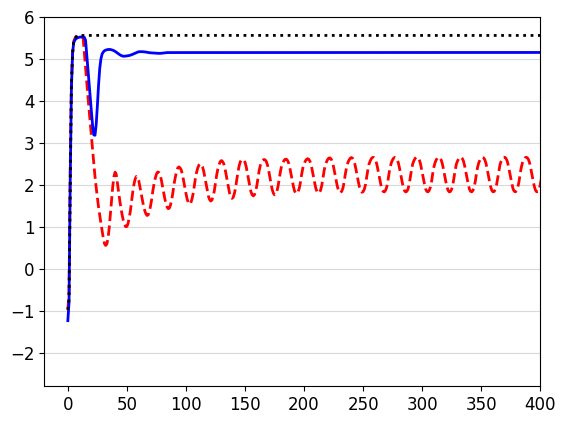

In [63]:
# plot utility value vs policy iterate
count = 0
for i in draw_index:
    stralpha = str(alpha_list[i])
    strlabel = "$\\alpha$ = "+ stralpha
    plt.plot(num_grads,np.array(resilient_utility[i][::num_every])+u_constraint, linewidth=2, label = strlabel, color = color_list[count], linestyle = linestyle[count])
    count+=1
# count = 0
# for i in draw_index:
#     stralpha = str(alpha_list[i])
#     strlabel = "$opt \\alpha$ = "+ stralpha
#     plt.plot(num_grads,np.array(opt_resilient_utility[i][::num_every])+u_constraint, linewidth=2, label = strlabel, color = color_list[count], linestyle = linestyle[count])
#     count+=1

plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
plt.xlim(yaxismin,yaxismax)
plt.ylim(-2.8,6)


plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
plt.savefig('AppUtilityVsIternopt.png', dpi = 300, bbox_inches='tight')
plt.show()





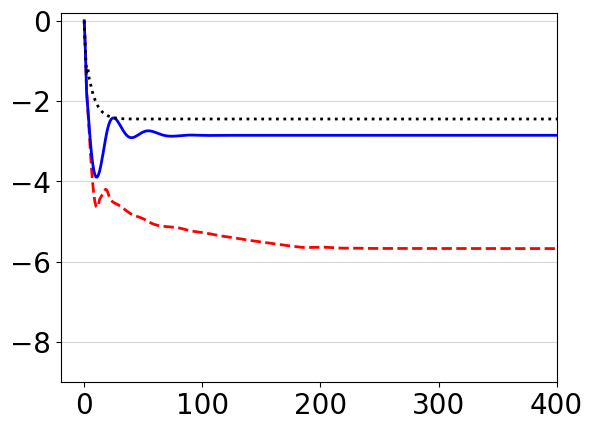

In [64]:
# plot relaxation value xi vs policy iterate
yaxixmax = 400
fontsize = 28
axisfontsize = 20

count = 0
# for i in draw_index:
#     stralpha = str(alpha_list[i])
#     strlabel = "$\\alpha$ = "+ stralpha
#     plt.plot(num_grads,resilient_xi[i][::num_every], linewidth=2, label = strlabel, color = color_list[count], linestyle = linestyle[count])
#     count+=1

count = 0
for i in draw_index:
    stralpha = str(alpha_list[i])
    strlabel = "opt $\\alpha$ = "+ stralpha
    plt.plot(num_grads,opt_resilient_xi[i][::num_every],linewidth=2, label = strlabel, color = color_list[count], linestyle = linestyle[count])
    count+=1


plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
plt.xlim(-20,yaxixmax)
plt.ylim(-9,0.2)

plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)

plt.savefig('XiVsIteropt.png', dpi = 300, bbox_inches='tight')
plt.show()

## Plot reward, utility, relaxation, policy optimality gaps

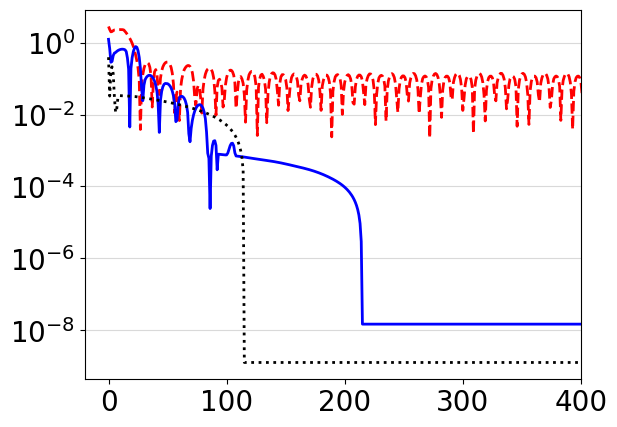

In [65]:
#plot the gap: 'reward': reward error; 'utility,: utility error, 'xi': xi error; 'dist':policy optimality gap

yaxismax = 400
plot = 'reward'

if plot == 'dist':
  count = 0
  for i in draw_index:
      stralpha = str(alpha_list[i])
      strlabel = "$opt \\alpha$ = "+ stralpha
      plt.plot(num_grads,dist[i][::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
      count+=1

elif plot == 'reward':
  count = 0

  for i in draw_index:
    stralpha = str(alpha_list[i])
    strlabel = "$\\alpha$ = "+ stralpha
    plt.plot(num_grads,np.absolute((np.array(resilient_reward[i])-optimal_dict[alpha_list[i]]['reward'][0][0]))[::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
    count+=1

  # for i in draw_index:
  #   stralpha = str(alpha_list[i])
  #   strlabel = "$\\alpha$ = "+ stralpha
  #   plt.plot(num_grads,np.absolute((np.array(opt_resilient_reward[i])-optimal_dict[alpha_list[i]]['reward'][0][0]))[::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
  #   count+=1


elif plot =='utility':
  count = 0
  # for i in draw_index:
  #   stralpha = str(alpha_list[i])
  #   strlabel = "$\\alpha$ = "+ stralpha
  #   plt.plot(num_grads,np.absolute(resilient_utility[i]-optimal_dict[alpha_list[i]]['utility'][0][0])[::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
  #   count+=1

  for i in draw_index:
    stralpha = str(alpha_list[i])
    strlabel = "$\\alpha$ = "+ stralpha
    plt.plot(num_grads,np.absolute(opt_resilient_utility[i]-optimal_dict[alpha_list[i]]['utility'][0][0])[::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
    count+=1

elif plot == 'xi':
  count = 0
  for i in draw_index:
    stralpha = str(alpha_list[i])
    strlabel = "$\\alpha$ = "+ stralpha
    plt.plot(num_grads,np.absolute((np.array(resilient_xi[i])-optimal_dict[alpha_list[i]]['xi']))[::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
    count+=1

  # for i in draw_index:
  #   stralpha = str(alpha_list[i])
  #   strlabel = "$\\alpha$ = "+ stralpha
  #   plt.plot(num_grads,np.absolute((np.array(opt_resilient_xi[i])-optimal_dict[alpha_list[i]]['xi']))[::num_every], linewidth=2, label = strlabel,color = color_list[count], linestyle = linestyle[count])
  #   count+=1

plt.grid(axis='y', color='0.85')
plt.draw()
get_f_value = plt.gcf()
plt.xlim(yaxismin,yaxismax)
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
plt.yscale('log')
plt.savefig('RewardVsIteropt.png', dpi = 300, bbox_inches='tight')

plt.show()

## Reward, utility, relaxation vs alpha

In [66]:
total_iterates = 2000 #10000
stepsize = 0.2


alpha_list = [0.002,0.005,0.01,0.015,0.03, 0.05,0.1,0.2,0.5,1]
opt_resilient_reward_last = []
opt_resilient_utility_last = []
opt_resilient_xi_last = []

resilient_reward_rangeub = []
resilient_utility_rangeub = []
resilient_xi_rangeub = []

resilient_reward_rangelb = []
resilient_utility_rangelb = []
resilient_xi_rangelb = []
for alpha in alpha_list:
    resilient_reward_value_opt, resilient_utility_value_opt, resilient_xi_value_opt = Opt_NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates, u_constraint, show_detail = False)
    opt_resilient_reward_last.append(resilient_reward_value_opt)
    opt_resilient_utility_last.append(resilient_utility_value_opt)
    opt_resilient_xi_last.append(resilient_xi_value_opt)

    resilient_reward_value_opt, resilient_utility_value_opt, resilient_xi_value_opt, policy_distance = NPG_primal_dual_resilient(n, m, prob_transition, gamma, reward, utility, stepsize, alpha, total_iterates,u_constraint, show_detail = True)
    resilient_reward_rangeub.append(max(resilient_reward_value_opt[total_iterates-500:]))
    resilient_utility_rangeub.append(max(resilient_utility_value_opt[total_iterates-500:]))
    resilient_xi_rangeub.append(max(resilient_xi_value_opt[total_iterates-500:]))

    resilient_reward_rangelb.append(min(resilient_reward_value_opt[total_iterates-500:]))
    resilient_utility_rangelb.append(min(resilient_utility_value_opt[total_iterates-500:]))
    resilient_xi_rangelb.append(min(resilient_xi_value_opt[total_iterates-500:]))

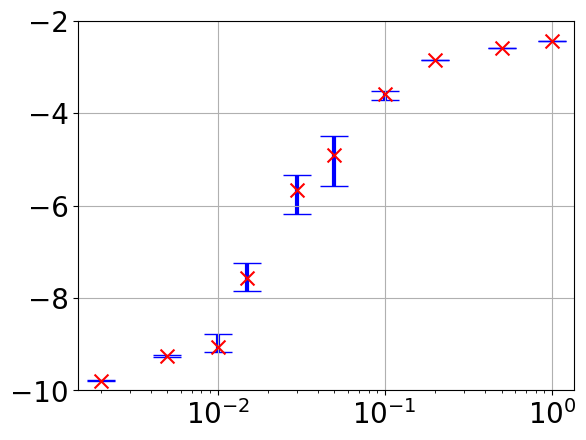

In [67]:
resilient_utility_rangeub = np.array(resilient_utility_rangeub)
resilient_utility_rangelb = np.array(resilient_utility_rangelb)
center = (resilient_utility_rangeub +resilient_utility_rangelb)/2
width = (resilient_utility_rangeub -resilient_utility_rangelb)/2

plt.errorbar(alpha_list, center, linestyle="None", yerr  = width, capsize = 10,  fmt = '' ,c='blue', linewidth=3, zorder = 1)
plt.scatter(alpha_list, opt_resilient_utility_last,label = 'optimistic', marker = 'x', color = 'red', s = 100, zorder = 2)
plt.xscale('log')
plt.grid()
plt.savefig('Utility value.png')
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
plt.ylim(-10,-2)
plt.savefig('UtilityVsAlpha.png', dpi = 300, bbox_inches='tight')
plt.show()

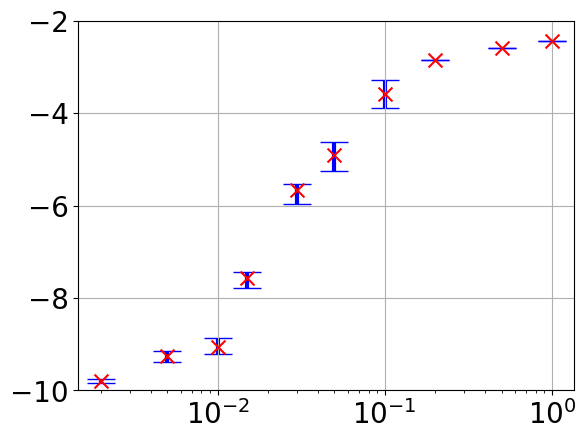

In [68]:
resilient_xi_rangeub = np.array(resilient_xi_rangeub)
resilient_xi_rangelb = np.array(resilient_xi_rangelb)
center = (resilient_xi_rangeub +resilient_xi_rangelb)/2
width = (resilient_xi_rangeub -resilient_xi_rangelb)/2

plt.errorbar(alpha_list, center, linestyle="None", yerr  = width, capsize = 10,  fmt = '' ,c='blue', linewidth=3, zorder = 1)
plt.scatter(alpha_list, opt_resilient_xi_last,label = 'optimistic', marker = 'x', color = 'red', s = 100, zorder = 2)
plt.xscale('log')

plt.grid()
plt.tick_params(axis='x', labelsize=axisfontsize)
plt.tick_params(axis='y', labelsize=axisfontsize)
plt.ylim(-10,-2)
plt.savefig('XiVsAlpha.png', dpi = 300, bbox_inches='tight')
plt.show()